In [48]:
# parser = argparse.ArgumentParser(description="Choose RNN module: LSTM or GRU")
# parser.add_argument("--rnn_module", type=str, default="LSTM", help="Choose RNN module: LSTM or GRU")
# args = parser.parse_args()

rnn = "GRU"

In [49]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

import matplotlib.pyplot as plt
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import scipy.io as sio

from tqdm import trange, tqdm
import argparse

# Import the quadruped model components from your second file
from mlp_quadruped_rnn import MLP, MLPQuadrupedProjectionFilter, CustomGRULayer, GRU_Hidden_State, CustomLSTMLayer, LSTM_Hidden_State


from scipy.spatial.transform import Rotation as R

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

/home/alinjar/simple_training_warm_start/Quadruped_qp
Using cuda device


In [50]:
class ForceDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, inp, desired_speed, desired_twisting_speed):
        # input
        self.inp = inp
        self.desired_speed = desired_speed
        self.desired_twisting_speed = desired_twisting_speed

    def __len__(self):
        return len(self.inp)    
        
    def __getitem__(self, idx):
        # Input
        inp = self.inp[idx]
        desired_speed = self.desired_speed[idx]
        desired_twisting_speed = self.desired_twisting_speed
        return torch.tensor(inp).float(), torch.tensor(desired_speed).float(), torch.tensor(desired_twisting_speed).float()    


def sample_uniform_variables(key, var_min, var_max, dataset_size, nvar):
    rng = np.random.default_rng(seed=key)
    xi_samples = rng.uniform(
        low=var_min,
        high=var_max,
        size=(dataset_size, nvar)
    )
    return xi_samples, rng


In [51]:


# Parameters for Quadruped Model
num_batch = 1
timestep = 0.05  # 50 Hz control frequency
horizon = 10     # prediction horizon steps
num_legs = 4
friction_coeff = 0.2
body_mass = 50.0  # kg

body_inertia=(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

# Desired motion parameters
# desired_speed_x_tensor, rng = sample_uniform_variable(42, -0.5, 0.5, 1, 1)
# desired_speed_x = desired_speed_x_tensor.squeeze().item()
# print("desired_speed_x", desired_speed_x)
desired_body_height = 0.5     # m


In [52]:
##Parameters for MLP model
# Default states
BaseRollPitchYaw = (0.0, 0.0, 0.0)
AngularVelocityBodyFrame = (0.0, 0.0, 0.0)
ComVelocityBodyFrame = (0.0, 0.0, 0.0)
FootContacts = (True, True, True, True)
slope_estimate = (0.0, 0.0, 0.0)
RotationBodyWrtWorld = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

roll, pitch, yaw = BaseRollPitchYaw

# Create rotation object from Euler angles (in radians)
rot = R.from_euler('xyz', [roll, pitch, yaw])

# Convert to rotation matrix
rotation_matrix = rot.as_matrix()  # Shape (3, 3)

# Flatten into a 9-element tuple (row-major order)
RotationBodyWrtWorld = tuple(rotation_matrix.flatten())
#self.RotationBodyWrtWorld = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


"""Setup foot positions and default states for quadruped"""
# Foot positions in body frame
foot_x=0.2
foot_y=0.2
foot_z=-desired_body_height

FootPositionsInBodyFrame = torch.tensor([
    [ foot_x,  foot_y, foot_z],
    [-foot_x,  foot_y, foot_z],
    [ foot_x, -foot_y, foot_z],
    [-foot_x, -foot_y, foot_z]])

# Define QP matrices for quadruped control (simplified example)
# In practice, these would come from your quadruped dynamics model




# Maximum Iterations
maxiter_projection = 10

nvar = 3*num_legs*horizon

num_total_constraints = 2*nvar


In [53]:
dataset_size = 1*num_batch
desired_speed_batched, rng_desired_speed_batched = sample_uniform_variables(None, var_min= -0.0, var_max = 0.0, dataset_size=dataset_size, nvar=2)
desired_twisting_speed_batched,  rng_desired_twisting_speed_batched = sample_uniform_variables(
                                                                      42, var_min= -0.0, var_max = 0.0, dataset_size=dataset_size, 
                                                                      nvar=1)

desired_speed_batched_val, rng_desired_speed_batched = sample_uniform_variables(None, var_min= -0.1, var_max = 0.1, dataset_size=dataset_size, nvar=2)
desired_twisting_speed_batched_val,  rng_desired_twisting_speed_batched = sample_uniform_variables(
                                                                      39, var_min= -0.1, var_max = 0.1, dataset_size=dataset_size,
                                                                      nvar=1)

print("desired_speed_batched.shape", desired_speed_batched.shape)
print("desired_twisting_speed_batched.shape", desired_twisting_speed_batched.shape)

inp = np.hstack((desired_speed_batched, desired_twisting_speed_batched))

inp_val = np.hstack(( desired_speed_batched_val, desired_twisting_speed_batched_val))

# Using PyTorch Dataloader
train_dataset = ForceDataset(inp, desired_speed_batched, desired_twisting_speed_batched)
val_dataset = ForceDataset(inp_val, desired_speed_batched_val, desired_twisting_speed_batched_val)

train_loader = DataLoader(train_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)


desired_speed_batched.shape (1, 2)
desired_twisting_speed_batched.shape (1, 1)


In [54]:
if rnn == "GRU":
    print("Training with GRU")
    #GRU handling
    rnn = "GRU"
    gru_input_size = 3*num_total_constraints+3*nvar
    # print(gru_input_size)
    gru_hidden_size = 512
    # gru_output_size = (2*nvar)**2+2*nvar
    gru_output_size = num_total_constraints+nvar
    # gru_context_size = mlp_planner_inp_dim

    gru_context = CustomGRULayer(gru_input_size, gru_hidden_size, gru_output_size)

    rnn_context = gru_context


    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = gru_hidden_size

    gru_init  =  GRU_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)
    
    rnn_init = gru_init
    ##
elif rnn == "LSTM":
    print("Training with LSTM")
    #LSTM handling
    rnn = "LSTM"
    lstm_input_size = 3*num_total_constraints+3*nvar
    # print(lstm_input_size)
    lstm_hidden_size = 512
    # lstm_output_size = (2*nvar)**2+2*nvar
    lstm_output_size = num_total_constraints+nvar
    # lstm_context_size = mlp_planner_inp_dim

    lstm_context = CustomLSTMLayer(lstm_input_size, lstm_hidden_size, lstm_output_size)

    rnn_context = lstm_context

    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = lstm_hidden_size

    lstm_init = LSTM_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)

    rnn_init = lstm_init

    ##


Training with GRU


In [55]:
# MLP setup
enc_inp_dim = np.shape(inp)[1] 
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 2*nvar + num_total_constraints  # xi_samples, lambda_samples, slack_variables

mlp = MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)


In [56]:

# Create the quadruped model
model = MLPQuadrupedProjectionFilter(
    mlp=mlp,
    rnn_context=rnn_context, 
    rnn_init=rnn_init, 
    num_batch=num_batch,
    maxiter_projection=maxiter_projection,
    BaseRollPitchYaw=BaseRollPitchYaw,
    AngularVelocityBodyFrame=AngularVelocityBodyFrame,
    ComVelocityBodyFrame=ComVelocityBodyFrame,
    FootPositionsInBodyFrame=FootPositionsInBodyFrame,
    FootContacts=FootContacts,
    slope_estimate=slope_estimate,
    RotationBodyWrtWorld=RotationBodyWrtWorld, 
    desired_body_height=desired_body_height,
    body_mass=body_mass,
    body_inertia=body_inertia,
    num_legs=num_legs,
    friction_coeff=friction_coeff,
    timestep=timestep,
    horizon=horizon,
    rnn=rnn).to(device)

print(f"Model type: {type(model)}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")


Model type: <class 'mlp_quadruped_rnn.MLPQuadrupedProjectionFilter'>
Number of parameters: 4869192


In [57]:
# Training
epochs = 1500
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=6e-5)

losses = []
last_loss = torch.inf
avg_train_loss, avg_primal_loss, avg_fixed_point_loss, avg_qp_cost_loss = [], [], [], []
avg_val_loss = []

for epoch in range(epochs):
    
    # Train Loop
    model.train()
    losses_train, primal_losses, fixed_point_losses, qp_cost_losses = [], [], [], []
    
    for (inp, desired_speed_batched, desired_twisting_speed_batched) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        
        desired_speed_batched, rng_desired_speed_batched = sample_uniform_variables(None, var_min= -2, var_max = 2, dataset_size=dataset_size, nvar=2)
        desired_twisting_speed_batched, rng_desired_twisting_speed_batched = sample_uniform_variables(None, var_min= -0.5, var_max = 0.5, 
                                                                                                     dataset_size=dataset_size, nvar=1)
        
        inp = np.hstack((desired_speed_batched, desired_twisting_speed_batched))

        #print("desired_speed_batched", desired_speed_batched)

        desired_speed_batched = torch.tensor(desired_speed_batched).float()
        desired_twisting_speed_batched = torch.tensor(desired_twisting_speed_batched).float()
        inp = torch.tensor(inp).float()

        # Input and Output 
        inp = inp.to(device)
        desired_speed_batched = desired_speed_batched.to(device)
        desired_twisting_speed_batched = desired_twisting_speed_batched.to(device)
        
        # Forward pass through quadruped model
        xi_projected, avg_res_fixed_point, avg_res_primal, avg_res_qp_cost, res_primal_history, res_fixed_point_history, _ = model(inp, desired_speed_batched, 
                                                                                                               desired_twisting_speed_batched, rnn)
        
        
        # Compute loss
        primal_loss, fixed_point_loss, qp_cost_loss ,loss = model.mlp_loss(
            avg_res_primal, avg_res_fixed_point, avg_res_qp_cost)

        optimizer.zero_grad()
        loss.backward()
        
        # Optional gradient clipping
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        losses_train.append(loss.detach().cpu().numpy()) 
        primal_losses.append(primal_loss.detach().cpu().numpy())
        fixed_point_losses.append(fixed_point_loss.detach().cpu().numpy())
        qp_cost_losses.append(qp_cost_loss.detach().cpu().numpy())
        #projection_losses.append(projection_loss.detach().cpu().numpy())
        
    # Validation every 2 epochs
    if epoch % 2 == 0:
        model.eval()
        val_losses = []

        with torch.no_grad():
            for (inp_val, desired_speed_batched_val, desired_twisting_speed_batched_val) in tqdm(val_loader, desc="Validation"):

                desired_speed_batched_val, rng_desired_speed_batched_val = sample_uniform_variables(None, var_min= -2, var_max = 2, dataset_size=dataset_size, nvar=2)
                desired_twisting_speed_batched_val, rng_desired_twisting_speed_batched_val = sample_uniform_variables(None, var_min= -0.5, var_max = 0.5, 
                                                                                                            dataset_size=dataset_size, nvar=1)
                
                inp_val = np.hstack((desired_speed_batched_val, desired_twisting_speed_batched_val))

                #print("desired_speed_batched", desired_speed_batched)

                desired_speed_batched_val = torch.tensor(desired_speed_batched_val).float()
                desired_twisting_speed_batched_val = torch.tensor(desired_twisting_speed_batched_val).float()
                inp_val = torch.tensor(inp_val).float()
                
                inp_val = inp_val.to(device)
                desired_speed_batched_val = desired_speed_batched_val.to(device)
                desired_twisting_speed_batched_val = desired_twisting_speed_batched_val.to(device)

                xi_projected, avg_res_fixed_point, avg_res_primal, avg_res_qp_cost, res_primal_history, res_fixed_point_history, _ = model(inp_val, desired_speed_batched_val, 
                                                                                                                       desired_twisting_speed_batched_val,
                                                                                                                       rnn)
                
                _, _, _, val_loss = model.mlp_loss(
                    avg_res_primal, avg_res_fixed_point, avg_res_qp_cost
                )

                val_losses.append(val_loss.detach().cpu().numpy())

    # Print progress every 2 epochs
    if epoch % 2 == 0:    
        print(
            f"Epoch: {epoch + 1}, Train Loss: {np.average(losses_train):.4f}, "
        )

              #f"Projection Loss: {np.average(projection_losses):.4f}")
        
        if len(val_losses) > 0:
            print(f"Validation Loss: {np.average(val_losses):.4f}")

    # Save best model
    os.makedirs("./training_weights", exist_ok=True)
    if loss <= last_loss:
        torch.save(model.state_dict(), f"./training_weights/mlp_learned_quadruped_{rnn}.pth")
        last_loss = loss

    # Store metrics
    avg_train_loss.append(np.average(losses_train))
    avg_primal_loss.append(np.average(primal_losses))
    avg_qp_cost_loss.append(np.average(qp_cost_losses))
    avg_fixed_point_loss.append(np.average(fixed_point_losses))
    
    if len(val_losses) > 0:
        avg_val_loss.append(np.average(val_losses))
    else:
        avg_val_loss.append(avg_val_loss[-1] if avg_val_loss else 0.0)

print("Training completed!")



Validation: 100%|██████████| 1/1 [00:00<00:00, 26.29it/s]


Epoch: 1, Train Loss: 20622.0312, 
Validation Loss: 8885.3691


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.21it/s]


Epoch: 3, Train Loss: 4528.4624, 
Validation Loss: 4398.2227


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.21it/s]


Epoch: 5, Train Loss: 7244.6187, 
Validation Loss: 5561.5894


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.26it/s]


Epoch: 7, Train Loss: 6412.8184, 
Validation Loss: 8852.7773


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.86it/s]


Epoch: 9, Train Loss: 4017.3555, 
Validation Loss: 3442.8687


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.87it/s]


Epoch: 11, Train Loss: 4468.8267, 
Validation Loss: 3652.9172


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.22it/s]


Epoch: 13, Train Loss: 5174.4888, 
Validation Loss: 5106.2778


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.22it/s]


Epoch: 15, Train Loss: 3641.9514, 
Validation Loss: 3230.8267


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.00it/s]


Epoch: 17, Train Loss: 3839.1958, 
Validation Loss: 3629.9871


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.99it/s]


Epoch: 19, Train Loss: 3107.1985, 
Validation Loss: 3154.7363


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.65it/s]


Epoch: 21, Train Loss: 2995.0217, 
Validation Loss: 2030.9380


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.94it/s]


Epoch: 23, Train Loss: 4192.9790, 
Validation Loss: 1783.7941


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.06it/s]


Epoch: 25, Train Loss: 1811.0034, 
Validation Loss: 1399.0021


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.70it/s]


Epoch: 27, Train Loss: 2182.6458, 
Validation Loss: 1877.8690


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.74it/s]


Epoch: 29, Train Loss: 1865.1517, 
Validation Loss: 1710.8556


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.63it/s]


Epoch: 31, Train Loss: 1570.2179, 
Validation Loss: 2298.2573


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


Epoch: 33, Train Loss: 3492.3682, 
Validation Loss: 1334.1881


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.66it/s]


Epoch: 35, Train Loss: 1639.1633, 
Validation Loss: 1593.6609


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.97it/s]


Epoch: 37, Train Loss: 1360.9084, 
Validation Loss: 1039.1300


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.18it/s]


Epoch: 39, Train Loss: 1021.5609, 
Validation Loss: 1029.8014


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.04it/s]


Epoch: 41, Train Loss: 1354.8883, 
Validation Loss: 1336.8715


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.44it/s]


Epoch: 43, Train Loss: 2388.7080, 
Validation Loss: 937.8890


Validation: 100%|██████████| 1/1 [00:00<00:00, 24.12it/s]


Epoch: 45, Train Loss: 2017.7399, 
Validation Loss: 1215.4806


Validation: 100%|██████████| 1/1 [00:00<00:00, 31.46it/s]


Epoch: 47, Train Loss: 1324.4000, 
Validation Loss: 1097.7435


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.08it/s]


Epoch: 49, Train Loss: 1271.0886, 
Validation Loss: 746.6222


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.43it/s]


Epoch: 51, Train Loss: 1732.9607, 
Validation Loss: 1263.5935


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.04it/s]


Epoch: 53, Train Loss: 967.8246, 
Validation Loss: 1280.1044


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.61it/s]


Epoch: 55, Train Loss: 2216.3669, 
Validation Loss: 709.1428


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.78it/s]


Epoch: 57, Train Loss: 1162.6758, 
Validation Loss: 770.3578


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.27it/s]


Epoch: 59, Train Loss: 1176.8883, 
Validation Loss: 494.9889


Validation: 100%|██████████| 1/1 [00:00<00:00, 24.93it/s]


Epoch: 61, Train Loss: 1640.9979, 
Validation Loss: 851.9052


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.77it/s]


Epoch: 63, Train Loss: 645.1906, 
Validation Loss: 914.7859


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.99it/s]


Epoch: 65, Train Loss: 1289.9408, 
Validation Loss: 927.9016


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.13it/s]


Epoch: 67, Train Loss: 1303.6094, 
Validation Loss: 348.8154


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.44it/s]


Epoch: 69, Train Loss: 537.3236, 
Validation Loss: 560.2792


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.78it/s]


Epoch: 71, Train Loss: 1190.1722, 
Validation Loss: 751.2643


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.82it/s]


Epoch: 73, Train Loss: 1024.8767, 
Validation Loss: 676.2189


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.92it/s]


Epoch: 75, Train Loss: 1107.5625, 
Validation Loss: 330.8593


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.38it/s]


Epoch: 77, Train Loss: 1328.5277, 
Validation Loss: 533.0638


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.29it/s]


Epoch: 79, Train Loss: 1018.7094, 
Validation Loss: 677.6644


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.40it/s]


Epoch: 81, Train Loss: 1432.5839, 
Validation Loss: 737.8514


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.81it/s]


Epoch: 83, Train Loss: 868.4279, 
Validation Loss: 556.5377


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.27it/s]


Epoch: 85, Train Loss: 1227.7877, 
Validation Loss: 1660.4257


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.08it/s]


Epoch: 87, Train Loss: 1365.5297, 
Validation Loss: 543.3849


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.22it/s]


Epoch: 89, Train Loss: 841.1820, 
Validation Loss: 897.0716


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.24it/s]


Epoch: 91, Train Loss: 915.5524, 
Validation Loss: 561.6539


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.44it/s]


Epoch: 93, Train Loss: 1384.9141, 
Validation Loss: 723.3503


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.53it/s]


Epoch: 95, Train Loss: 1271.4515, 
Validation Loss: 1652.0654


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.92it/s]


Epoch: 97, Train Loss: 1540.1354, 
Validation Loss: 867.6080


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.31it/s]


Epoch: 99, Train Loss: 1166.8778, 
Validation Loss: 468.5528


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.34it/s]


Epoch: 101, Train Loss: 1079.0336, 
Validation Loss: 626.7549


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.90it/s]


Epoch: 103, Train Loss: 1277.5206, 
Validation Loss: 605.6304


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.75it/s]


Epoch: 105, Train Loss: 629.9239, 
Validation Loss: 596.6104


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.30it/s]


Epoch: 107, Train Loss: 791.7526, 
Validation Loss: 525.7621


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.80it/s]


Epoch: 109, Train Loss: 1557.4181, 
Validation Loss: 469.5456


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.79it/s]


Epoch: 111, Train Loss: 709.9991, 
Validation Loss: 393.1409


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.85it/s]


Epoch: 113, Train Loss: 687.3845, 
Validation Loss: 366.3892


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.19it/s]


Epoch: 115, Train Loss: 994.4653, 
Validation Loss: 396.0573


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.73it/s]


Epoch: 117, Train Loss: 578.7438, 
Validation Loss: 371.0755


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.51it/s]


Epoch: 119, Train Loss: 877.8632, 
Validation Loss: 276.7988


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.88it/s]


Epoch: 121, Train Loss: 767.6492, 
Validation Loss: 397.9758


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.52it/s]


Epoch: 123, Train Loss: 677.4364, 
Validation Loss: 473.6188


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.27it/s]


Epoch: 125, Train Loss: 721.1340, 
Validation Loss: 467.6437


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.55it/s]


Epoch: 127, Train Loss: 850.6649, 
Validation Loss: 762.7632


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.98it/s]


Epoch: 129, Train Loss: 701.2953, 
Validation Loss: 707.5036


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.08it/s]


Epoch: 131, Train Loss: 705.1496, 
Validation Loss: 381.2495


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.74it/s]


Epoch: 133, Train Loss: 871.4245, 
Validation Loss: 406.8266


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.47it/s]


Epoch: 135, Train Loss: 898.5510, 
Validation Loss: 556.3313


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.98it/s]


Epoch: 137, Train Loss: 656.8337, 
Validation Loss: 354.3314


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.06it/s]


Epoch: 139, Train Loss: 786.1060, 
Validation Loss: 401.2899


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.78it/s]


Epoch: 141, Train Loss: 1169.1046, 
Validation Loss: 491.6539


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.46it/s]


Epoch: 143, Train Loss: 662.0229, 
Validation Loss: 335.8905


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.23it/s]


Epoch: 145, Train Loss: 417.5398, 
Validation Loss: 400.8795


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.99it/s]


Epoch: 147, Train Loss: 816.3454, 
Validation Loss: 422.2071


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.00it/s]


Epoch: 149, Train Loss: 763.8917, 
Validation Loss: 679.5264


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.93it/s]


Epoch: 151, Train Loss: 594.5745, 
Validation Loss: 307.0282


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.06it/s]


Epoch: 153, Train Loss: 495.8856, 
Validation Loss: 488.3217


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.90it/s]


Epoch: 155, Train Loss: 759.5323, 
Validation Loss: 263.9652


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.98it/s]


Epoch: 157, Train Loss: 436.9501, 
Validation Loss: 437.9583


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.75it/s]


Epoch: 159, Train Loss: 443.6670, 
Validation Loss: 336.1490


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.09it/s]


Epoch: 161, Train Loss: 701.8143, 
Validation Loss: 196.5421


Validation: 100%|██████████| 1/1 [00:00<00:00, 24.12it/s]


Epoch: 163, Train Loss: 610.9031, 
Validation Loss: 200.9121


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.96it/s]


Epoch: 165, Train Loss: 646.1401, 
Validation Loss: 200.4437


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.88it/s]


Epoch: 167, Train Loss: 477.8169, 
Validation Loss: 323.5558


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.70it/s]


Epoch: 169, Train Loss: 808.7851, 
Validation Loss: 260.7501


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.13it/s]


Epoch: 171, Train Loss: 586.6852, 
Validation Loss: 261.1642


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.02it/s]


Epoch: 173, Train Loss: 405.6121, 
Validation Loss: 347.7574


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.64it/s]


Epoch: 175, Train Loss: 434.2279, 
Validation Loss: 567.3433


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.54it/s]


Epoch: 177, Train Loss: 559.0934, 
Validation Loss: 168.6228


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.31it/s]


Epoch: 179, Train Loss: 482.0408, 
Validation Loss: 224.7690


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.85it/s]


Epoch: 181, Train Loss: 479.9112, 
Validation Loss: 257.7485


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.53it/s]


Epoch: 183, Train Loss: 770.5491, 
Validation Loss: 317.0403


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.89it/s]


Epoch: 185, Train Loss: 771.5760, 
Validation Loss: 325.2460


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.65it/s]


Epoch: 187, Train Loss: 344.0194, 
Validation Loss: 481.9766


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.23it/s]


Epoch: 189, Train Loss: 559.9584, 
Validation Loss: 543.8614


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.47it/s]


Epoch: 191, Train Loss: 570.3106, 
Validation Loss: 313.4058


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.54it/s]


Epoch: 193, Train Loss: 499.5817, 
Validation Loss: 316.6576


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.98it/s]


Epoch: 195, Train Loss: 710.7235, 
Validation Loss: 442.6450


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.83it/s]


Epoch: 197, Train Loss: 481.3991, 
Validation Loss: 300.7025


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.36it/s]


Epoch: 199, Train Loss: 425.8632, 
Validation Loss: 242.3472


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.46it/s]


Epoch: 201, Train Loss: 590.0483, 
Validation Loss: 236.1761


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.60it/s]


Epoch: 203, Train Loss: 482.8706, 
Validation Loss: 190.2432


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.29it/s]


Epoch: 205, Train Loss: 340.3602, 
Validation Loss: 171.5280


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.14it/s]


Epoch: 207, Train Loss: 248.5060, 
Validation Loss: 213.8273


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.93it/s]


Epoch: 209, Train Loss: 720.1095, 
Validation Loss: 331.2574


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.61it/s]


Epoch: 211, Train Loss: 574.4913, 
Validation Loss: 213.5500


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.68it/s]


Epoch: 213, Train Loss: 320.6468, 
Validation Loss: 250.0083


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.38it/s]


Epoch: 215, Train Loss: 565.5614, 
Validation Loss: 288.3991


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.56it/s]


Epoch: 217, Train Loss: 556.7565, 
Validation Loss: 248.2946


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.35it/s]


Epoch: 219, Train Loss: 427.8255, 
Validation Loss: 304.0048


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.81it/s]


Epoch: 221, Train Loss: 671.8918, 
Validation Loss: 436.7235


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.85it/s]


Epoch: 223, Train Loss: 484.4106, 
Validation Loss: 122.9919


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.84it/s]


Epoch: 225, Train Loss: 515.5541, 
Validation Loss: 344.4710


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.66it/s]


Epoch: 227, Train Loss: 351.4864, 
Validation Loss: 343.5012


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.82it/s]


Epoch: 229, Train Loss: 415.6261, 
Validation Loss: 209.7199


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.13it/s]


Epoch: 231, Train Loss: 684.1189, 
Validation Loss: 259.1517


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.56it/s]


Epoch: 233, Train Loss: 360.3912, 
Validation Loss: 226.6844


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.18it/s]


Epoch: 235, Train Loss: 719.4105, 
Validation Loss: 285.7287


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.48it/s]


Epoch: 237, Train Loss: 714.6058, 
Validation Loss: 266.3533


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.62it/s]


Epoch: 239, Train Loss: 345.5337, 
Validation Loss: 327.6546


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.03it/s]


Epoch: 241, Train Loss: 534.4755, 
Validation Loss: 269.0925


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.14it/s]


Epoch: 243, Train Loss: 329.6655, 
Validation Loss: 264.6187


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.95it/s]


Epoch: 245, Train Loss: 470.2821, 
Validation Loss: 380.9253


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.26it/s]


Epoch: 247, Train Loss: 595.2703, 
Validation Loss: 285.8182


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.06it/s]


Epoch: 249, Train Loss: 517.7642, 
Validation Loss: 258.7377


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.83it/s]


Epoch: 251, Train Loss: 378.6679, 
Validation Loss: 299.7900


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.61it/s]


Epoch: 253, Train Loss: 349.8038, 
Validation Loss: 312.2193


Validation: 100%|██████████| 1/1 [00:00<00:00, 24.91it/s]


Epoch: 255, Train Loss: 672.3699, 
Validation Loss: 336.3246


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.50it/s]


Epoch: 257, Train Loss: 237.1971, 
Validation Loss: 257.9439


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.43it/s]


Epoch: 259, Train Loss: 519.3979, 
Validation Loss: 166.0172


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.25it/s]


Epoch: 261, Train Loss: 674.5710, 
Validation Loss: 261.1259


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.22it/s]


Epoch: 263, Train Loss: 355.8692, 
Validation Loss: 190.3511


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.66it/s]


Epoch: 265, Train Loss: 329.7408, 
Validation Loss: 290.7341


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.70it/s]


Epoch: 267, Train Loss: 279.9362, 
Validation Loss: 197.4521


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.75it/s]


Epoch: 269, Train Loss: 405.6711, 
Validation Loss: 267.5451


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.18it/s]


Epoch: 271, Train Loss: 411.8870, 
Validation Loss: 179.3143


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.32it/s]


Epoch: 273, Train Loss: 338.9892, 
Validation Loss: 151.9432


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.85it/s]


Epoch: 275, Train Loss: 268.1262, 
Validation Loss: 282.3896


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.65it/s]


Epoch: 277, Train Loss: 243.5656, 
Validation Loss: 440.0619


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.54it/s]


Epoch: 279, Train Loss: 332.3537, 
Validation Loss: 159.8345


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.19it/s]


Epoch: 281, Train Loss: 280.3069, 
Validation Loss: 202.1622


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.68it/s]


Epoch: 283, Train Loss: 546.9151, 
Validation Loss: 271.9153


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


Epoch: 285, Train Loss: 385.7679, 
Validation Loss: 271.8709


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.24it/s]


Epoch: 287, Train Loss: 404.4050, 
Validation Loss: 242.2914


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.50it/s]


Epoch: 289, Train Loss: 432.4271, 
Validation Loss: 514.4141


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.33it/s]


Epoch: 291, Train Loss: 350.5939, 
Validation Loss: 219.7209


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.49it/s]


Epoch: 293, Train Loss: 438.2877, 
Validation Loss: 224.4341


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.90it/s]


Epoch: 295, Train Loss: 399.0019, 
Validation Loss: 253.5489


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.31it/s]


Epoch: 297, Train Loss: 319.4071, 
Validation Loss: 164.8226


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.54it/s]


Epoch: 299, Train Loss: 497.2929, 
Validation Loss: 213.3788


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.30it/s]


Epoch: 301, Train Loss: 337.2352, 
Validation Loss: 232.2431


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.53it/s]


Epoch: 303, Train Loss: 437.9489, 
Validation Loss: 199.1192


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.23it/s]


Epoch: 305, Train Loss: 302.2937, 
Validation Loss: 272.9402


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.25it/s]


Epoch: 307, Train Loss: 308.2392, 
Validation Loss: 263.1347


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.83it/s]


Epoch: 309, Train Loss: 386.5367, 
Validation Loss: 119.9698


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.69it/s]


Epoch: 311, Train Loss: 312.1716, 
Validation Loss: 329.6720


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.49it/s]


Epoch: 313, Train Loss: 521.3088, 
Validation Loss: 333.4658


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.35it/s]


Epoch: 315, Train Loss: 343.6511, 
Validation Loss: 287.0797


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.13it/s]


Epoch: 317, Train Loss: 318.0721, 
Validation Loss: 174.5204


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.53it/s]


Epoch: 319, Train Loss: 434.3655, 
Validation Loss: 202.1449


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.54it/s]


Epoch: 321, Train Loss: 269.1347, 
Validation Loss: 239.4483


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.14it/s]


Epoch: 323, Train Loss: 224.6939, 
Validation Loss: 154.9299


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.84it/s]


Epoch: 325, Train Loss: 221.7735, 
Validation Loss: 221.8661


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.36it/s]


Epoch: 327, Train Loss: 363.8058, 
Validation Loss: 174.4059


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.66it/s]


Epoch: 329, Train Loss: 274.6209, 
Validation Loss: 226.7858


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.02it/s]


Epoch: 331, Train Loss: 299.4601, 
Validation Loss: 232.2928


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.99it/s]


Epoch: 333, Train Loss: 437.0948, 
Validation Loss: 141.5460


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.52it/s]


Epoch: 335, Train Loss: 418.4529, 
Validation Loss: 166.2050


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.61it/s]


Epoch: 337, Train Loss: 344.8795, 
Validation Loss: 130.4270


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


Epoch: 339, Train Loss: 261.3199, 
Validation Loss: 124.8696


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.47it/s]


Epoch: 341, Train Loss: 286.8620, 
Validation Loss: 291.9591


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.44it/s]


Epoch: 343, Train Loss: 363.0809, 
Validation Loss: 160.2934


Validation: 100%|██████████| 1/1 [00:00<00:00, 24.90it/s]


Epoch: 345, Train Loss: 330.8160, 
Validation Loss: 175.1574


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.91it/s]


Epoch: 347, Train Loss: 348.4864, 
Validation Loss: 200.9977


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.42it/s]


Epoch: 349, Train Loss: 228.2444, 
Validation Loss: 221.0464


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.65it/s]


Epoch: 351, Train Loss: 408.6600, 
Validation Loss: 205.4459


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.99it/s]


Epoch: 353, Train Loss: 289.6646, 
Validation Loss: 255.6381


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.15it/s]


Epoch: 355, Train Loss: 434.3280, 
Validation Loss: 194.7070


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.56it/s]


Epoch: 357, Train Loss: 318.5441, 
Validation Loss: 146.1133


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.07it/s]


Epoch: 359, Train Loss: 480.1898, 
Validation Loss: 302.8112


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.32it/s]


Epoch: 361, Train Loss: 468.7098, 
Validation Loss: 170.6255


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.05it/s]


Epoch: 363, Train Loss: 267.7273, 
Validation Loss: 166.9516


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.11it/s]


Epoch: 365, Train Loss: 355.6472, 
Validation Loss: 235.5448


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.05it/s]


Epoch: 367, Train Loss: 402.2980, 
Validation Loss: 197.9264


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.50it/s]


Epoch: 369, Train Loss: 550.2671, 
Validation Loss: 141.7853


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.01it/s]


Epoch: 371, Train Loss: 310.2965, 
Validation Loss: 153.0441


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.34it/s]


Epoch: 373, Train Loss: 247.3822, 
Validation Loss: 235.8314


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.81it/s]


Epoch: 375, Train Loss: 548.8132, 
Validation Loss: 168.7935


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.40it/s]


Epoch: 377, Train Loss: 369.9157, 
Validation Loss: 164.1768


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.16it/s]


Epoch: 379, Train Loss: 417.9328, 
Validation Loss: 216.5585


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.64it/s]


Epoch: 381, Train Loss: 412.9397, 
Validation Loss: 249.0847


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.98it/s]


Epoch: 383, Train Loss: 339.9343, 
Validation Loss: 209.7285


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.10it/s]


Epoch: 385, Train Loss: 377.6176, 
Validation Loss: 183.1072


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.59it/s]


Epoch: 387, Train Loss: 345.3183, 
Validation Loss: 139.8483


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.34it/s]


Epoch: 389, Train Loss: 398.9688, 
Validation Loss: 202.3206


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.78it/s]


Epoch: 391, Train Loss: 197.2132, 
Validation Loss: 153.8423


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.95it/s]


Epoch: 393, Train Loss: 378.0742, 
Validation Loss: 184.3569


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.81it/s]


Epoch: 395, Train Loss: 387.3895, 
Validation Loss: 162.6433


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.08it/s]


Epoch: 397, Train Loss: 386.2731, 
Validation Loss: 310.5358


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.21it/s]


Epoch: 399, Train Loss: 684.3167, 
Validation Loss: 170.2546


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.17it/s]


Epoch: 401, Train Loss: 303.6846, 
Validation Loss: 207.6370


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.41it/s]


Epoch: 403, Train Loss: 342.1000, 
Validation Loss: 216.0247


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.26it/s]


Epoch: 405, Train Loss: 308.1149, 
Validation Loss: 193.4681


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.70it/s]


Epoch: 407, Train Loss: 310.8557, 
Validation Loss: 144.2036


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.30it/s]


Epoch: 409, Train Loss: 293.2304, 
Validation Loss: 242.7931


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.41it/s]


Epoch: 411, Train Loss: 265.0855, 
Validation Loss: 132.3935


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.50it/s]


Epoch: 413, Train Loss: 207.8331, 
Validation Loss: 260.3255


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.05it/s]


Epoch: 415, Train Loss: 425.5434, 
Validation Loss: 143.2585


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.41it/s]


Epoch: 417, Train Loss: 372.7381, 
Validation Loss: 216.3062


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.27it/s]


Epoch: 419, Train Loss: 342.8935, 
Validation Loss: 357.5051


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.97it/s]


Epoch: 421, Train Loss: 302.4501, 
Validation Loss: 210.6245


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.85it/s]


Epoch: 423, Train Loss: 299.5080, 
Validation Loss: 235.7384


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.09it/s]


Epoch: 425, Train Loss: 174.1056, 
Validation Loss: 95.5434


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.88it/s]


Epoch: 427, Train Loss: 576.2492, 
Validation Loss: 108.5194


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.10it/s]


Epoch: 429, Train Loss: 297.3757, 
Validation Loss: 179.5623


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.16it/s]


Epoch: 431, Train Loss: 373.1679, 
Validation Loss: 110.4762


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.77it/s]


Epoch: 433, Train Loss: 368.2941, 
Validation Loss: 267.2415


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.36it/s]


Epoch: 435, Train Loss: 261.3622, 
Validation Loss: 244.2921


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.90it/s]


Epoch: 437, Train Loss: 471.1738, 
Validation Loss: 201.5079


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.18it/s]


Epoch: 439, Train Loss: 360.4080, 
Validation Loss: 168.6836


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.80it/s]


Epoch: 441, Train Loss: 292.3202, 
Validation Loss: 205.9066


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.22it/s]


Epoch: 443, Train Loss: 266.6743, 
Validation Loss: 204.3067


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.60it/s]


Epoch: 445, Train Loss: 252.7491, 
Validation Loss: 177.9550


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.47it/s]


Epoch: 447, Train Loss: 280.0549, 
Validation Loss: 144.2899


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.76it/s]


Epoch: 449, Train Loss: 336.5862, 
Validation Loss: 137.0810


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.10it/s]


Epoch: 451, Train Loss: 172.5141, 
Validation Loss: 106.5570


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.20it/s]


Epoch: 453, Train Loss: 274.4426, 
Validation Loss: 192.0585


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.19it/s]


Epoch: 455, Train Loss: 201.1342, 
Validation Loss: 93.2751


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.95it/s]


Epoch: 457, Train Loss: 341.5954, 
Validation Loss: 156.7159


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.91it/s]


Epoch: 459, Train Loss: 162.3219, 
Validation Loss: 171.4014


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.26it/s]


Epoch: 461, Train Loss: 284.3542, 
Validation Loss: 150.6219


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.52it/s]


Epoch: 463, Train Loss: 259.0253, 
Validation Loss: 178.8094


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.16it/s]


Epoch: 465, Train Loss: 462.3701, 
Validation Loss: 186.8853


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.76it/s]


Epoch: 467, Train Loss: 302.5981, 
Validation Loss: 208.6210


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.82it/s]


Epoch: 469, Train Loss: 323.2612, 
Validation Loss: 278.9443


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.49it/s]


Epoch: 471, Train Loss: 335.7458, 
Validation Loss: 148.9215


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.38it/s]


Epoch: 473, Train Loss: 251.3934, 
Validation Loss: 125.3107


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.77it/s]


Epoch: 475, Train Loss: 241.3137, 
Validation Loss: 185.7434


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.35it/s]


Epoch: 477, Train Loss: 371.0938, 
Validation Loss: 109.9516


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.09it/s]


Epoch: 479, Train Loss: 225.2558, 
Validation Loss: 70.4791


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.47it/s]


Epoch: 481, Train Loss: 259.5827, 
Validation Loss: 80.8176


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.01it/s]


Epoch: 483, Train Loss: 360.8304, 
Validation Loss: 89.5010


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.69it/s]


Epoch: 485, Train Loss: 260.9209, 
Validation Loss: 104.0476


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.66it/s]


Epoch: 487, Train Loss: 231.7487, 
Validation Loss: 97.6382


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.95it/s]


Epoch: 489, Train Loss: 180.8015, 
Validation Loss: 75.7774


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.79it/s]


Epoch: 491, Train Loss: 217.3720, 
Validation Loss: 114.2435


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.30it/s]


Epoch: 493, Train Loss: 257.0731, 
Validation Loss: 94.3437


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.08it/s]


Epoch: 495, Train Loss: 129.6236, 
Validation Loss: 116.1364


Validation: 100%|██████████| 1/1 [00:00<00:00, 31.48it/s]


Epoch: 497, Train Loss: 224.8580, 
Validation Loss: 135.4386


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.98it/s]


Epoch: 499, Train Loss: 249.9857, 
Validation Loss: 119.5423


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.80it/s]


Epoch: 501, Train Loss: 172.7494, 
Validation Loss: 140.7512


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.80it/s]


Epoch: 503, Train Loss: 186.2543, 
Validation Loss: 115.3224


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.50it/s]


Epoch: 505, Train Loss: 168.6922, 
Validation Loss: 102.4393


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.70it/s]


Epoch: 507, Train Loss: 238.3337, 
Validation Loss: 62.7779


Validation: 100%|██████████| 1/1 [00:00<00:00, 23.41it/s]


Epoch: 509, Train Loss: 250.9431, 
Validation Loss: 94.7523


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.83it/s]


Epoch: 511, Train Loss: 203.4627, 
Validation Loss: 202.8930


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.59it/s]


Epoch: 513, Train Loss: 195.9967, 
Validation Loss: 129.6033


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.32it/s]


Epoch: 515, Train Loss: 141.2249, 
Validation Loss: 200.0318


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.06it/s]


Epoch: 517, Train Loss: 154.7435, 
Validation Loss: 151.4059


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.81it/s]


Epoch: 519, Train Loss: 240.9485, 
Validation Loss: 149.9760


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.65it/s]


Epoch: 521, Train Loss: 310.9760, 
Validation Loss: 83.8502


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.49it/s]


Epoch: 523, Train Loss: 226.9396, 
Validation Loss: 143.1697


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.14it/s]


Epoch: 525, Train Loss: 271.5945, 
Validation Loss: 120.0676


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.99it/s]


Epoch: 527, Train Loss: 218.3571, 
Validation Loss: 113.2286


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.01it/s]


Epoch: 529, Train Loss: 206.6479, 
Validation Loss: 142.7243


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.45it/s]


Epoch: 531, Train Loss: 369.3798, 
Validation Loss: 104.9021


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.79it/s]


Epoch: 533, Train Loss: 175.1222, 
Validation Loss: 113.5265


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.22it/s]


Epoch: 535, Train Loss: 166.9472, 
Validation Loss: 126.3919


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.45it/s]


Epoch: 537, Train Loss: 171.2352, 
Validation Loss: 115.1047


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.80it/s]


Epoch: 539, Train Loss: 319.1857, 
Validation Loss: 162.3780


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.36it/s]


Epoch: 541, Train Loss: 233.1981, 
Validation Loss: 118.4353


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.48it/s]


Epoch: 543, Train Loss: 162.5055, 
Validation Loss: 141.4966


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.07it/s]


Epoch: 545, Train Loss: 391.2032, 
Validation Loss: 266.6530


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.71it/s]


Epoch: 547, Train Loss: 212.7506, 
Validation Loss: 106.6539


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.21it/s]


Epoch: 549, Train Loss: 214.4331, 
Validation Loss: 107.6078


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.74it/s]


Epoch: 551, Train Loss: 434.3779, 
Validation Loss: 203.6886


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.64it/s]


Epoch: 553, Train Loss: 179.2946, 
Validation Loss: 135.0759


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.53it/s]


Epoch: 555, Train Loss: 242.1112, 
Validation Loss: 176.2428


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.99it/s]


Epoch: 557, Train Loss: 201.6956, 
Validation Loss: 93.1962


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.49it/s]


Epoch: 559, Train Loss: 210.7479, 
Validation Loss: 90.5799


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.25it/s]


Epoch: 561, Train Loss: 260.8008, 
Validation Loss: 123.9534


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.13it/s]


Epoch: 563, Train Loss: 230.1331, 
Validation Loss: 117.7589


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.73it/s]


Epoch: 565, Train Loss: 116.1464, 
Validation Loss: 89.5911


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.53it/s]


Epoch: 567, Train Loss: 124.1009, 
Validation Loss: 58.6734


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.02it/s]


Epoch: 569, Train Loss: 261.9875, 
Validation Loss: 70.3387


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.40it/s]


Epoch: 571, Train Loss: 303.9881, 
Validation Loss: 62.0594


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.28it/s]


Epoch: 573, Train Loss: 178.7071, 
Validation Loss: 94.9219


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.94it/s]


Epoch: 575, Train Loss: 176.9404, 
Validation Loss: 71.9368


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.34it/s]


Epoch: 577, Train Loss: 174.7452, 
Validation Loss: 65.9389


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.38it/s]


Epoch: 579, Train Loss: 154.2010, 
Validation Loss: 121.7752


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.36it/s]


Epoch: 581, Train Loss: 232.1670, 
Validation Loss: 71.2315


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.98it/s]


Epoch: 583, Train Loss: 176.0784, 
Validation Loss: 56.2071


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.39it/s]


Epoch: 585, Train Loss: 110.8980, 
Validation Loss: 79.3912


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.18it/s]


Epoch: 587, Train Loss: 187.8709, 
Validation Loss: 65.4331


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.39it/s]


Epoch: 589, Train Loss: 107.5540, 
Validation Loss: 54.3202


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.30it/s]


Epoch: 591, Train Loss: 132.9684, 
Validation Loss: 69.7101


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


Epoch: 593, Train Loss: 121.2710, 
Validation Loss: 83.3602


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.03it/s]


Epoch: 595, Train Loss: 188.2516, 
Validation Loss: 70.4512


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.24it/s]


Epoch: 597, Train Loss: 100.3910, 
Validation Loss: 42.5571


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.53it/s]


Epoch: 599, Train Loss: 145.3872, 
Validation Loss: 90.8343


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.55it/s]


Epoch: 601, Train Loss: 141.0597, 
Validation Loss: 97.0231


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.86it/s]


Epoch: 603, Train Loss: 168.0401, 
Validation Loss: 49.6377


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.95it/s]


Epoch: 605, Train Loss: 155.7895, 
Validation Loss: 90.2056


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.23it/s]


Epoch: 607, Train Loss: 201.5601, 
Validation Loss: 70.7040


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.23it/s]


Epoch: 609, Train Loss: 168.5741, 
Validation Loss: 72.2039


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.28it/s]


Epoch: 611, Train Loss: 160.7690, 
Validation Loss: 99.4361


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.19it/s]


Epoch: 613, Train Loss: 90.4156, 
Validation Loss: 73.9705


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.90it/s]


Epoch: 615, Train Loss: 182.3654, 
Validation Loss: 88.5808


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.77it/s]


Epoch: 617, Train Loss: 310.8297, 
Validation Loss: 73.9818


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.89it/s]


Epoch: 619, Train Loss: 200.8379, 
Validation Loss: 96.1028


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.75it/s]


Epoch: 621, Train Loss: 121.4676, 
Validation Loss: 103.6483


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.32it/s]


Epoch: 623, Train Loss: 213.1011, 
Validation Loss: 136.3539


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.74it/s]


Epoch: 625, Train Loss: 121.3056, 
Validation Loss: 58.8037


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.42it/s]


Epoch: 627, Train Loss: 238.1428, 
Validation Loss: 164.6250


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.56it/s]


Epoch: 629, Train Loss: 159.8519, 
Validation Loss: 73.7642


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.53it/s]


Epoch: 631, Train Loss: 170.8313, 
Validation Loss: 66.7402


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.78it/s]


Epoch: 633, Train Loss: 162.1407, 
Validation Loss: 89.9379


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.33it/s]


Epoch: 635, Train Loss: 131.1981, 
Validation Loss: 133.8699


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.31it/s]


Epoch: 637, Train Loss: 125.3873, 
Validation Loss: 126.1528


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.52it/s]


Epoch: 639, Train Loss: 181.4608, 
Validation Loss: 76.5399


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.75it/s]


Epoch: 641, Train Loss: 166.3354, 
Validation Loss: 135.7043


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.66it/s]


Epoch: 643, Train Loss: 345.3881, 
Validation Loss: 54.4460


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.97it/s]


Epoch: 645, Train Loss: 138.9606, 
Validation Loss: 127.7366


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.94it/s]


Epoch: 647, Train Loss: 161.5372, 
Validation Loss: 84.5082


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.02it/s]


Epoch: 649, Train Loss: 205.0825, 
Validation Loss: 76.3075


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.62it/s]


Epoch: 651, Train Loss: 157.3051, 
Validation Loss: 100.0971


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.53it/s]


Epoch: 653, Train Loss: 250.9853, 
Validation Loss: 98.5492


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.29it/s]


Epoch: 655, Train Loss: 144.2270, 
Validation Loss: 69.4603


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.45it/s]


Epoch: 657, Train Loss: 176.0245, 
Validation Loss: 61.3270


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.29it/s]


Epoch: 659, Train Loss: 255.3894, 
Validation Loss: 72.3501


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.93it/s]


Epoch: 661, Train Loss: 182.3706, 
Validation Loss: 126.1667


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.41it/s]


Epoch: 663, Train Loss: 167.5013, 
Validation Loss: 126.5376


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.08it/s]


Epoch: 665, Train Loss: 146.0601, 
Validation Loss: 101.4800


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.87it/s]


Epoch: 667, Train Loss: 240.4560, 
Validation Loss: 62.0117


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.24it/s]


Epoch: 669, Train Loss: 155.1652, 
Validation Loss: 46.7392


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.23it/s]


Epoch: 671, Train Loss: 153.0987, 
Validation Loss: 98.9047


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.74it/s]


Epoch: 673, Train Loss: 130.1154, 
Validation Loss: 79.6790


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.14it/s]


Epoch: 675, Train Loss: 160.9027, 
Validation Loss: 87.4533


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.18it/s]


Epoch: 677, Train Loss: 156.7617, 
Validation Loss: 68.6752


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.80it/s]


Epoch: 679, Train Loss: 154.3709, 
Validation Loss: 84.1314


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.27it/s]


Epoch: 681, Train Loss: 108.7243, 
Validation Loss: 80.4060


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.56it/s]


Epoch: 683, Train Loss: 160.5187, 
Validation Loss: 74.6457


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.86it/s]


Epoch: 685, Train Loss: 153.2013, 
Validation Loss: 64.6056


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.31it/s]


Epoch: 687, Train Loss: 108.8413, 
Validation Loss: 116.4176


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.44it/s]


Epoch: 689, Train Loss: 205.3771, 
Validation Loss: 69.8912


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.00it/s]


Epoch: 691, Train Loss: 133.6360, 
Validation Loss: 70.6601


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.37it/s]


Epoch: 693, Train Loss: 100.4420, 
Validation Loss: 59.0601


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.43it/s]


Epoch: 695, Train Loss: 138.2249, 
Validation Loss: 73.0296


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.08it/s]


Epoch: 697, Train Loss: 221.7631, 
Validation Loss: 101.7057


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.27it/s]


Epoch: 699, Train Loss: 172.8966, 
Validation Loss: 101.7376


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.22it/s]


Epoch: 701, Train Loss: 234.1395, 
Validation Loss: 134.2535


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.31it/s]


Epoch: 703, Train Loss: 264.4496, 
Validation Loss: 89.7904


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.69it/s]


Epoch: 705, Train Loss: 126.6233, 
Validation Loss: 98.8180


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.48it/s]


Epoch: 707, Train Loss: 244.9353, 
Validation Loss: 91.8030


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.05it/s]


Epoch: 709, Train Loss: 81.5653, 
Validation Loss: 84.7277


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.77it/s]


Epoch: 711, Train Loss: 160.5714, 
Validation Loss: 65.6878


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.26it/s]


Epoch: 713, Train Loss: 156.5875, 
Validation Loss: 60.2119


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.25it/s]


Epoch: 715, Train Loss: 142.5210, 
Validation Loss: 64.9667


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.61it/s]


Epoch: 717, Train Loss: 153.8449, 
Validation Loss: 84.0340


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.42it/s]


Epoch: 719, Train Loss: 133.8465, 
Validation Loss: 65.1968


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.42it/s]


Epoch: 721, Train Loss: 133.8801, 
Validation Loss: 78.2694


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.86it/s]


Epoch: 723, Train Loss: 206.0096, 
Validation Loss: 66.9307


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.03it/s]


Epoch: 725, Train Loss: 146.4207, 
Validation Loss: 135.3605


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.76it/s]


Epoch: 727, Train Loss: 244.4790, 
Validation Loss: 87.2981


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.87it/s]


Epoch: 729, Train Loss: 155.2589, 
Validation Loss: 62.1733


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.49it/s]


Epoch: 731, Train Loss: 193.0531, 
Validation Loss: 125.6715


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.63it/s]


Epoch: 733, Train Loss: 235.1965, 
Validation Loss: 104.1742


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.77it/s]


Epoch: 735, Train Loss: 125.5762, 
Validation Loss: 86.3224


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.61it/s]


Epoch: 737, Train Loss: 241.2625, 
Validation Loss: 161.7291


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.56it/s]


Epoch: 739, Train Loss: 226.5838, 
Validation Loss: 85.7636


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.90it/s]


Epoch: 741, Train Loss: 182.7920, 
Validation Loss: 116.1258


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.02it/s]


Epoch: 743, Train Loss: 119.8972, 
Validation Loss: 90.5736


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.70it/s]


Epoch: 745, Train Loss: 183.8443, 
Validation Loss: 98.7109


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.79it/s]


Epoch: 747, Train Loss: 193.6665, 
Validation Loss: 94.0743


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.97it/s]


Epoch: 749, Train Loss: 206.5644, 
Validation Loss: 118.3754


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.53it/s]


Epoch: 751, Train Loss: 161.4265, 
Validation Loss: 77.4656


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.36it/s]


Epoch: 753, Train Loss: 213.9248, 
Validation Loss: 71.2461


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.97it/s]


Epoch: 755, Train Loss: 145.7524, 
Validation Loss: 101.0155


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.44it/s]


Epoch: 757, Train Loss: 155.3137, 
Validation Loss: 80.8267


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.19it/s]


Epoch: 759, Train Loss: 101.0815, 
Validation Loss: 105.5034


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.40it/s]


Epoch: 761, Train Loss: 123.0901, 
Validation Loss: 100.0214


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.27it/s]


Epoch: 763, Train Loss: 156.9069, 
Validation Loss: 51.1779


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.83it/s]


Epoch: 765, Train Loss: 155.5216, 
Validation Loss: 76.5866


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.01it/s]


Epoch: 767, Train Loss: 205.2547, 
Validation Loss: 78.5001


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.28it/s]


Epoch: 769, Train Loss: 88.9222, 
Validation Loss: 103.0703


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.81it/s]


Epoch: 771, Train Loss: 133.7243, 
Validation Loss: 64.6522


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.64it/s]


Epoch: 773, Train Loss: 98.3861, 
Validation Loss: 87.3994


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.21it/s]


Epoch: 775, Train Loss: 90.2501, 
Validation Loss: 44.1151


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.83it/s]


Epoch: 777, Train Loss: 143.0217, 
Validation Loss: 45.5470


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.79it/s]


Epoch: 779, Train Loss: 228.0984, 
Validation Loss: 60.3034


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.87it/s]


Epoch: 781, Train Loss: 141.6157, 
Validation Loss: 57.7549


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.92it/s]


Epoch: 783, Train Loss: 139.7142, 
Validation Loss: 101.1474


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.36it/s]


Epoch: 785, Train Loss: 175.0666, 
Validation Loss: 68.0073


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.21it/s]


Epoch: 787, Train Loss: 122.3971, 
Validation Loss: 73.5944


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.69it/s]


Epoch: 789, Train Loss: 207.4859, 
Validation Loss: 57.7500


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.31it/s]


Epoch: 791, Train Loss: 130.4014, 
Validation Loss: 95.1775


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.25it/s]


Epoch: 793, Train Loss: 273.5279, 
Validation Loss: 89.1575


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.80it/s]


Epoch: 795, Train Loss: 95.4947, 
Validation Loss: 87.0791


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.19it/s]


Epoch: 797, Train Loss: 205.4786, 
Validation Loss: 96.7446


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.65it/s]


Epoch: 799, Train Loss: 108.7920, 
Validation Loss: 40.5896


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.44it/s]


Epoch: 801, Train Loss: 85.6761, 
Validation Loss: 64.7528


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.88it/s]


Epoch: 803, Train Loss: 138.7930, 
Validation Loss: 48.3036


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.55it/s]


Epoch: 805, Train Loss: 114.3487, 
Validation Loss: 100.0811


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.75it/s]


Epoch: 807, Train Loss: 141.6668, 
Validation Loss: 52.2047


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.93it/s]


Epoch: 809, Train Loss: 112.6135, 
Validation Loss: 71.7644


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.55it/s]


Epoch: 811, Train Loss: 216.3717, 
Validation Loss: 98.6169


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.75it/s]


Epoch: 813, Train Loss: 135.7438, 
Validation Loss: 78.8373


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.65it/s]


Epoch: 815, Train Loss: 173.0727, 
Validation Loss: 50.4631


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.73it/s]


Epoch: 817, Train Loss: 107.9568, 
Validation Loss: 83.9044


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.65it/s]


Epoch: 819, Train Loss: 151.4374, 
Validation Loss: 80.9775


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.07it/s]


Epoch: 821, Train Loss: 156.8549, 
Validation Loss: 91.8518


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.24it/s]


Epoch: 823, Train Loss: 124.0450, 
Validation Loss: 108.9141


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.97it/s]


Epoch: 825, Train Loss: 182.1885, 
Validation Loss: 99.9113


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.90it/s]


Epoch: 827, Train Loss: 115.5247, 
Validation Loss: 49.5625


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.36it/s]


Epoch: 829, Train Loss: 143.3585, 
Validation Loss: 66.5407


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.28it/s]


Epoch: 831, Train Loss: 149.5660, 
Validation Loss: 74.6025


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.68it/s]


Epoch: 833, Train Loss: 177.0004, 
Validation Loss: 68.9072


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.44it/s]


Epoch: 835, Train Loss: 135.6262, 
Validation Loss: 97.2679


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.99it/s]


Epoch: 837, Train Loss: 113.8000, 
Validation Loss: 88.7635


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.22it/s]


Epoch: 839, Train Loss: 163.9069, 
Validation Loss: 71.0515


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.78it/s]


Epoch: 841, Train Loss: 158.8055, 
Validation Loss: 56.1535


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.97it/s]


Epoch: 843, Train Loss: 173.1372, 
Validation Loss: 90.2528


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.11it/s]


Epoch: 845, Train Loss: 140.6859, 
Validation Loss: 135.6930


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.01it/s]


Epoch: 847, Train Loss: 172.0757, 
Validation Loss: 110.8316


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.87it/s]


Epoch: 849, Train Loss: 155.0007, 
Validation Loss: 85.7370


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.39it/s]


Epoch: 851, Train Loss: 164.4766, 
Validation Loss: 120.2459


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.36it/s]


Epoch: 853, Train Loss: 244.2907, 
Validation Loss: 77.6568


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.01it/s]


Epoch: 855, Train Loss: 151.0985, 
Validation Loss: 92.3720


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.26it/s]


Epoch: 857, Train Loss: 222.9986, 
Validation Loss: 157.6408


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.63it/s]


Epoch: 859, Train Loss: 193.2358, 
Validation Loss: 92.5390


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.76it/s]


Epoch: 861, Train Loss: 88.8653, 
Validation Loss: 119.5654


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.61it/s]


Epoch: 863, Train Loss: 213.5794, 
Validation Loss: 96.3860


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.98it/s]


Epoch: 865, Train Loss: 127.1479, 
Validation Loss: 50.6515


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.03it/s]


Epoch: 867, Train Loss: 111.6950, 
Validation Loss: 123.1492


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.55it/s]


Epoch: 869, Train Loss: 160.5871, 
Validation Loss: 83.9541


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.68it/s]


Epoch: 871, Train Loss: 160.4789, 
Validation Loss: 74.4377


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.22it/s]


Epoch: 873, Train Loss: 151.0948, 
Validation Loss: 134.1264


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.88it/s]


Epoch: 875, Train Loss: 208.1955, 
Validation Loss: 62.8333


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.41it/s]


Epoch: 877, Train Loss: 176.2532, 
Validation Loss: 205.8471


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.26it/s]


Epoch: 879, Train Loss: 152.5337, 
Validation Loss: 54.7735


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.85it/s]


Epoch: 881, Train Loss: 100.8141, 
Validation Loss: 74.9923


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.18it/s]


Epoch: 883, Train Loss: 133.3540, 
Validation Loss: 85.0730


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.44it/s]


Epoch: 885, Train Loss: 282.9837, 
Validation Loss: 67.2886


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.20it/s]


Epoch: 887, Train Loss: 140.2700, 
Validation Loss: 72.5334


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.88it/s]


Epoch: 889, Train Loss: 185.3795, 
Validation Loss: 62.5878


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.26it/s]


Epoch: 891, Train Loss: 122.9362, 
Validation Loss: 89.7735


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.52it/s]


Epoch: 893, Train Loss: 123.6457, 
Validation Loss: 85.6408


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.04it/s]


Epoch: 895, Train Loss: 138.1535, 
Validation Loss: 63.7244


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.60it/s]


Epoch: 897, Train Loss: 198.1525, 
Validation Loss: 133.9817


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.36it/s]


Epoch: 899, Train Loss: 196.1378, 
Validation Loss: 79.5365


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.71it/s]


Epoch: 901, Train Loss: 149.5389, 
Validation Loss: 75.8947


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.93it/s]


Epoch: 903, Train Loss: 126.7145, 
Validation Loss: 107.6662


Validation: 100%|██████████| 1/1 [00:00<00:00, 24.69it/s]


Epoch: 905, Train Loss: 188.5218, 
Validation Loss: 110.9278


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.07it/s]


Epoch: 907, Train Loss: 105.7178, 
Validation Loss: 90.4166


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.16it/s]


Epoch: 909, Train Loss: 132.8517, 
Validation Loss: 48.6128


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.43it/s]


Epoch: 911, Train Loss: 126.6429, 
Validation Loss: 64.2952


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.57it/s]


Epoch: 913, Train Loss: 177.7961, 
Validation Loss: 67.0281


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.76it/s]


Epoch: 915, Train Loss: 118.2506, 
Validation Loss: 72.9634


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.55it/s]


Epoch: 917, Train Loss: 124.0187, 
Validation Loss: 60.3273


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.44it/s]


Epoch: 919, Train Loss: 105.4445, 
Validation Loss: 63.1844


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.25it/s]


Epoch: 921, Train Loss: 127.3354, 
Validation Loss: 65.5742


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.83it/s]


Epoch: 923, Train Loss: 144.9833, 
Validation Loss: 68.8554


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.78it/s]


Epoch: 925, Train Loss: 67.9887, 
Validation Loss: 49.8665


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.42it/s]


Epoch: 927, Train Loss: 99.1846, 
Validation Loss: 49.1558


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.81it/s]


Epoch: 929, Train Loss: 93.1398, 
Validation Loss: 72.9124


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.59it/s]


Epoch: 931, Train Loss: 106.9414, 
Validation Loss: 62.2259


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.51it/s]


Epoch: 933, Train Loss: 93.5845, 
Validation Loss: 50.5409


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.03it/s]


Epoch: 935, Train Loss: 111.7928, 
Validation Loss: 65.5292


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.96it/s]


Epoch: 937, Train Loss: 187.1148, 
Validation Loss: 62.1641


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.43it/s]


Epoch: 939, Train Loss: 128.3248, 
Validation Loss: 51.1613


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.40it/s]


Epoch: 941, Train Loss: 136.8851, 
Validation Loss: 71.9003


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.86it/s]


Epoch: 943, Train Loss: 164.8277, 
Validation Loss: 62.0161


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.18it/s]


Epoch: 945, Train Loss: 97.0122, 
Validation Loss: 52.4418


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.47it/s]


Epoch: 947, Train Loss: 116.2673, 
Validation Loss: 59.0468


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.29it/s]


Epoch: 949, Train Loss: 135.1597, 
Validation Loss: 62.3423


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.02it/s]


Epoch: 951, Train Loss: 102.5199, 
Validation Loss: 53.1065


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.12it/s]


Epoch: 953, Train Loss: 105.6065, 
Validation Loss: 65.3532


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.41it/s]


Epoch: 955, Train Loss: 144.9412, 
Validation Loss: 53.9296


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.09it/s]


Epoch: 957, Train Loss: 102.5934, 
Validation Loss: 72.4240


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.75it/s]


Epoch: 959, Train Loss: 118.9482, 
Validation Loss: 61.1132


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.29it/s]


Epoch: 961, Train Loss: 98.2421, 
Validation Loss: 48.1232


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.66it/s]


Epoch: 963, Train Loss: 107.2692, 
Validation Loss: 63.5904


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.56it/s]


Epoch: 965, Train Loss: 140.1991, 
Validation Loss: 57.6709


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.70it/s]


Epoch: 967, Train Loss: 91.4553, 
Validation Loss: 56.5605


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.33it/s]


Epoch: 969, Train Loss: 116.4500, 
Validation Loss: 71.4080


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.49it/s]


Epoch: 971, Train Loss: 149.2722, 
Validation Loss: 72.6182


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.00it/s]


Epoch: 973, Train Loss: 120.4462, 
Validation Loss: 43.7314


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.16it/s]


Epoch: 975, Train Loss: 89.4955, 
Validation Loss: 94.2642


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.08it/s]


Epoch: 977, Train Loss: 152.7748, 
Validation Loss: 43.0719


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.64it/s]


Epoch: 979, Train Loss: 205.1640, 
Validation Loss: 113.8653


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.60it/s]


Epoch: 981, Train Loss: 114.8207, 
Validation Loss: 85.0533


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.29it/s]


Epoch: 983, Train Loss: 179.4377, 
Validation Loss: 60.6764


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.88it/s]


Epoch: 985, Train Loss: 131.3463, 
Validation Loss: 85.0145


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.96it/s]


Epoch: 987, Train Loss: 143.6355, 
Validation Loss: 104.4948


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.39it/s]


Epoch: 989, Train Loss: 120.6362, 
Validation Loss: 90.7786


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.30it/s]


Epoch: 991, Train Loss: 99.8940, 
Validation Loss: 69.6022


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.51it/s]


Epoch: 993, Train Loss: 98.9821, 
Validation Loss: 80.5760


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.63it/s]


Epoch: 995, Train Loss: 182.8664, 
Validation Loss: 76.7768


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.78it/s]


Epoch: 997, Train Loss: 117.2115, 
Validation Loss: 42.3914


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.44it/s]


Epoch: 999, Train Loss: 103.4584, 
Validation Loss: 51.9056


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.44it/s]


Epoch: 1001, Train Loss: 101.1928, 
Validation Loss: 100.1348


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.29it/s]


Epoch: 1003, Train Loss: 134.6615, 
Validation Loss: 101.8132


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.60it/s]


Epoch: 1005, Train Loss: 164.2192, 
Validation Loss: 74.6137


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.94it/s]


Epoch: 1007, Train Loss: 38.9758, 
Validation Loss: 51.6980


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.35it/s]


Epoch: 1009, Train Loss: 114.2274, 
Validation Loss: 63.4441


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.50it/s]


Epoch: 1011, Train Loss: 116.5186, 
Validation Loss: 92.8618


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.65it/s]


Epoch: 1013, Train Loss: 183.2501, 
Validation Loss: 72.8978


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.20it/s]


Epoch: 1015, Train Loss: 132.9614, 
Validation Loss: 69.4060


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.59it/s]


Epoch: 1017, Train Loss: 130.9225, 
Validation Loss: 109.3036


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.31it/s]


Epoch: 1019, Train Loss: 86.5898, 
Validation Loss: 69.4877


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.93it/s]


Epoch: 1021, Train Loss: 114.4397, 
Validation Loss: 43.1928


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.39it/s]


Epoch: 1023, Train Loss: 111.6485, 
Validation Loss: 82.9378


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.59it/s]


Epoch: 1025, Train Loss: 104.5291, 
Validation Loss: 38.1767


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.92it/s]


Epoch: 1027, Train Loss: 69.3616, 
Validation Loss: 50.0915


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.73it/s]


Epoch: 1029, Train Loss: 143.3077, 
Validation Loss: 40.9170


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.60it/s]


Epoch: 1031, Train Loss: 88.1338, 
Validation Loss: 53.4672


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.57it/s]


Epoch: 1033, Train Loss: 126.8429, 
Validation Loss: 42.5093


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.26it/s]


Epoch: 1035, Train Loss: 79.7769, 
Validation Loss: 49.0226


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.34it/s]


Epoch: 1037, Train Loss: 93.3705, 
Validation Loss: 37.7148


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.79it/s]


Epoch: 1039, Train Loss: 98.6556, 
Validation Loss: 39.3450


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.57it/s]


Epoch: 1041, Train Loss: 100.9354, 
Validation Loss: 53.7791


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.84it/s]


Epoch: 1043, Train Loss: 130.1143, 
Validation Loss: 54.6965


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.86it/s]


Epoch: 1045, Train Loss: 64.6056, 
Validation Loss: 70.7176


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.39it/s]


Epoch: 1047, Train Loss: 89.1054, 
Validation Loss: 57.8741


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.64it/s]


Epoch: 1049, Train Loss: 185.3002, 
Validation Loss: 42.0207


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.14it/s]


Epoch: 1051, Train Loss: 78.1185, 
Validation Loss: 91.2208


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.45it/s]


Epoch: 1053, Train Loss: 140.0450, 
Validation Loss: 69.0026


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.07it/s]


Epoch: 1055, Train Loss: 115.4657, 
Validation Loss: 79.1586


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.70it/s]


Epoch: 1057, Train Loss: 119.2402, 
Validation Loss: 59.2711


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.56it/s]


Epoch: 1059, Train Loss: 87.2647, 
Validation Loss: 30.7938


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.66it/s]


Epoch: 1061, Train Loss: 98.3762, 
Validation Loss: 48.9620


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.53it/s]


Epoch: 1063, Train Loss: 87.3526, 
Validation Loss: 34.8835


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.86it/s]


Epoch: 1065, Train Loss: 110.9043, 
Validation Loss: 37.5597


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.72it/s]


Epoch: 1067, Train Loss: 60.8114, 
Validation Loss: 57.2906


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.37it/s]


Epoch: 1069, Train Loss: 70.0663, 
Validation Loss: 45.8761


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.50it/s]


Epoch: 1071, Train Loss: 107.8603, 
Validation Loss: 40.9748


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.38it/s]


Epoch: 1073, Train Loss: 90.1758, 
Validation Loss: 48.1119


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.05it/s]


Epoch: 1075, Train Loss: 135.9568, 
Validation Loss: 38.9412


Validation: 100%|██████████| 1/1 [00:00<00:00, 24.78it/s]


Epoch: 1077, Train Loss: 102.3771, 
Validation Loss: 47.7532


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.61it/s]


Epoch: 1079, Train Loss: 100.2719, 
Validation Loss: 60.0070


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.08it/s]


Epoch: 1081, Train Loss: 84.2915, 
Validation Loss: 73.7960


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.79it/s]


Epoch: 1083, Train Loss: 141.1357, 
Validation Loss: 58.6382


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.71it/s]


Epoch: 1085, Train Loss: 80.4109, 
Validation Loss: 49.3856


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.29it/s]


Epoch: 1087, Train Loss: 92.5597, 
Validation Loss: 72.1623


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.77it/s]


Epoch: 1089, Train Loss: 142.9919, 
Validation Loss: 98.0657


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.16it/s]


Epoch: 1091, Train Loss: 134.9173, 
Validation Loss: 58.9308


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.62it/s]


Epoch: 1093, Train Loss: 114.1271, 
Validation Loss: 54.3641


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.68it/s]


Epoch: 1095, Train Loss: 108.3517, 
Validation Loss: 72.2111


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.95it/s]


Epoch: 1097, Train Loss: 114.4798, 
Validation Loss: 76.8600


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.22it/s]


Epoch: 1099, Train Loss: 66.8490, 
Validation Loss: 35.3623


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.28it/s]


Epoch: 1101, Train Loss: 51.9445, 
Validation Loss: 80.3777


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.58it/s]


Epoch: 1103, Train Loss: 105.5624, 
Validation Loss: 37.1844


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.58it/s]


Epoch: 1105, Train Loss: 134.4658, 
Validation Loss: 70.6228


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.63it/s]


Epoch: 1107, Train Loss: 101.1072, 
Validation Loss: 51.7004


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.06it/s]


Epoch: 1109, Train Loss: 133.8102, 
Validation Loss: 54.4293


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.30it/s]


Epoch: 1111, Train Loss: 140.6548, 
Validation Loss: 54.5159


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.42it/s]


Epoch: 1113, Train Loss: 83.6713, 
Validation Loss: 62.9712


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.81it/s]


Epoch: 1115, Train Loss: 152.0307, 
Validation Loss: 47.2611


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.33it/s]


Epoch: 1117, Train Loss: 108.4777, 
Validation Loss: 107.6731


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.39it/s]


Epoch: 1119, Train Loss: 138.2462, 
Validation Loss: 89.3691


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.74it/s]


Epoch: 1121, Train Loss: 110.4231, 
Validation Loss: 78.2041


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.97it/s]


Epoch: 1123, Train Loss: 146.4438, 
Validation Loss: 94.4437


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.44it/s]


Epoch: 1125, Train Loss: 112.2938, 
Validation Loss: 66.7156


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.54it/s]


Epoch: 1127, Train Loss: 91.4380, 
Validation Loss: 72.1725


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.45it/s]


Epoch: 1129, Train Loss: 57.4679, 
Validation Loss: 39.8084


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.40it/s]


Epoch: 1131, Train Loss: 112.5538, 
Validation Loss: 55.2055


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.21it/s]


Epoch: 1133, Train Loss: 78.4269, 
Validation Loss: 45.4494


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.68it/s]


Epoch: 1135, Train Loss: 96.8607, 
Validation Loss: 45.4832


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.30it/s]


Epoch: 1137, Train Loss: 63.6753, 
Validation Loss: 46.8285


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.96it/s]


Epoch: 1139, Train Loss: 100.7493, 
Validation Loss: 53.8622


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.33it/s]


Epoch: 1141, Train Loss: 78.4734, 
Validation Loss: 33.0676


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.65it/s]


Epoch: 1143, Train Loss: 71.5818, 
Validation Loss: 76.2367


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.12it/s]


Epoch: 1145, Train Loss: 82.8787, 
Validation Loss: 51.7456


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.11it/s]


Epoch: 1147, Train Loss: 77.7799, 
Validation Loss: 87.5133


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.52it/s]


Epoch: 1149, Train Loss: 115.7346, 
Validation Loss: 57.6270


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.16it/s]


Epoch: 1151, Train Loss: 57.1773, 
Validation Loss: 66.6822


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.38it/s]


Epoch: 1153, Train Loss: 143.9805, 
Validation Loss: 52.9142


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.40it/s]


Epoch: 1155, Train Loss: 87.8118, 
Validation Loss: 46.8574


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.32it/s]


Epoch: 1157, Train Loss: 99.6336, 
Validation Loss: 77.9603


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.31it/s]


Epoch: 1159, Train Loss: 105.1888, 
Validation Loss: 49.6457


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.03it/s]


Epoch: 1161, Train Loss: 125.3383, 
Validation Loss: 55.3419


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.70it/s]


Epoch: 1163, Train Loss: 77.5795, 
Validation Loss: 74.7121


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.72it/s]


Epoch: 1165, Train Loss: 82.8641, 
Validation Loss: 37.8577


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.72it/s]


Epoch: 1167, Train Loss: 85.5178, 
Validation Loss: 51.2871


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.68it/s]


Epoch: 1169, Train Loss: 82.6336, 
Validation Loss: 55.4841


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.90it/s]


Epoch: 1171, Train Loss: 117.1606, 
Validation Loss: 42.8745


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.88it/s]


Epoch: 1173, Train Loss: 55.9965, 
Validation Loss: 58.0704


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.69it/s]


Epoch: 1175, Train Loss: 69.6000, 
Validation Loss: 41.5402


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.99it/s]


Epoch: 1177, Train Loss: 104.0655, 
Validation Loss: 44.7377


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.48it/s]


Epoch: 1179, Train Loss: 71.8897, 
Validation Loss: 41.5651


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.12it/s]


Epoch: 1181, Train Loss: 73.2312, 
Validation Loss: 52.9154


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.85it/s]


Epoch: 1183, Train Loss: 77.4434, 
Validation Loss: 60.3859


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.67it/s]


Epoch: 1185, Train Loss: 79.4927, 
Validation Loss: 30.1414


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.01it/s]


Epoch: 1187, Train Loss: 130.3176, 
Validation Loss: 77.5983


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.85it/s]


Epoch: 1189, Train Loss: 110.4697, 
Validation Loss: 36.6776


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.47it/s]


Epoch: 1191, Train Loss: 80.1263, 
Validation Loss: 45.8520


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.80it/s]


Epoch: 1193, Train Loss: 116.3448, 
Validation Loss: 60.6009


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.06it/s]


Epoch: 1195, Train Loss: 76.5692, 
Validation Loss: 49.1132


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.10it/s]


Epoch: 1197, Train Loss: 60.6855, 
Validation Loss: 62.7878


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.41it/s]


Epoch: 1199, Train Loss: 78.6661, 
Validation Loss: 50.8789


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.63it/s]


Epoch: 1201, Train Loss: 149.6565, 
Validation Loss: 74.2122


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.15it/s]


Epoch: 1203, Train Loss: 126.7487, 
Validation Loss: 43.9609


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.49it/s]


Epoch: 1205, Train Loss: 114.0553, 
Validation Loss: 42.2583


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.49it/s]


Epoch: 1207, Train Loss: 72.2628, 
Validation Loss: 41.0031


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.26it/s]


Epoch: 1209, Train Loss: 84.2876, 
Validation Loss: 79.4622


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.55it/s]


Epoch: 1211, Train Loss: 124.8819, 
Validation Loss: 86.0426


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.11it/s]


Epoch: 1213, Train Loss: 88.6865, 
Validation Loss: 46.9110


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.64it/s]


Epoch: 1215, Train Loss: 177.1788, 
Validation Loss: 59.8465


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.26it/s]


Epoch: 1217, Train Loss: 71.1419, 
Validation Loss: 42.6438


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.00it/s]


Epoch: 1219, Train Loss: 90.1598, 
Validation Loss: 81.5575


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.91it/s]


Epoch: 1221, Train Loss: 124.5483, 
Validation Loss: 59.4820


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.93it/s]


Epoch: 1223, Train Loss: 36.9431, 
Validation Loss: 53.1955


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.27it/s]


Epoch: 1225, Train Loss: 129.6556, 
Validation Loss: 61.9632


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.80it/s]


Epoch: 1227, Train Loss: 85.9661, 
Validation Loss: 53.2730


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.81it/s]


Epoch: 1229, Train Loss: 78.8064, 
Validation Loss: 46.4899


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.88it/s]


Epoch: 1231, Train Loss: 115.4356, 
Validation Loss: 55.7045


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.50it/s]


Epoch: 1233, Train Loss: 106.9053, 
Validation Loss: 67.6391


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.88it/s]


Epoch: 1235, Train Loss: 77.4938, 
Validation Loss: 48.5934


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.59it/s]


Epoch: 1237, Train Loss: 131.9839, 
Validation Loss: 82.4478


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.33it/s]


Epoch: 1239, Train Loss: 48.1057, 
Validation Loss: 39.8994


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.28it/s]


Epoch: 1241, Train Loss: 116.6196, 
Validation Loss: 59.9833


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.60it/s]


Epoch: 1243, Train Loss: 103.8664, 
Validation Loss: 42.1876


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.99it/s]


Epoch: 1245, Train Loss: 35.3013, 
Validation Loss: 60.1865


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.80it/s]


Epoch: 1247, Train Loss: 112.7243, 
Validation Loss: 43.7054


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.82it/s]


Epoch: 1249, Train Loss: 44.0865, 
Validation Loss: 46.0152


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.64it/s]


Epoch: 1251, Train Loss: 102.2298, 
Validation Loss: 42.7858


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.23it/s]


Epoch: 1253, Train Loss: 55.5881, 
Validation Loss: 44.3151


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.70it/s]


Epoch: 1255, Train Loss: 95.5357, 
Validation Loss: 45.1081


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.66it/s]


Epoch: 1257, Train Loss: 87.5136, 
Validation Loss: 37.0514


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.19it/s]


Epoch: 1259, Train Loss: 69.2538, 
Validation Loss: 45.5433


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.22it/s]


Epoch: 1261, Train Loss: 109.1530, 
Validation Loss: 44.3067


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.43it/s]


Epoch: 1263, Train Loss: 102.9705, 
Validation Loss: 46.8658


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.63it/s]


Epoch: 1265, Train Loss: 83.3767, 
Validation Loss: 51.4150


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.59it/s]


Epoch: 1267, Train Loss: 55.2222, 
Validation Loss: 47.5246


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.48it/s]


Epoch: 1269, Train Loss: 103.0691, 
Validation Loss: 70.2898


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.39it/s]


Epoch: 1271, Train Loss: 68.8724, 
Validation Loss: 46.2662


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.13it/s]


Epoch: 1273, Train Loss: 94.2839, 
Validation Loss: 64.0290


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.44it/s]


Epoch: 1275, Train Loss: 153.4432, 
Validation Loss: 60.6046


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.46it/s]


Epoch: 1277, Train Loss: 70.0575, 
Validation Loss: 53.3825


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.69it/s]


Epoch: 1279, Train Loss: 93.6916, 
Validation Loss: 92.1588


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.58it/s]


Epoch: 1281, Train Loss: 165.7096, 
Validation Loss: 45.5360


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.68it/s]


Epoch: 1283, Train Loss: 63.7441, 
Validation Loss: 65.3167


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.36it/s]


Epoch: 1285, Train Loss: 60.4258, 
Validation Loss: 51.9647


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.95it/s]


Epoch: 1287, Train Loss: 99.4016, 
Validation Loss: 41.5868


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.55it/s]


Epoch: 1289, Train Loss: 93.9696, 
Validation Loss: 52.4376


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.14it/s]


Epoch: 1291, Train Loss: 54.0328, 
Validation Loss: 71.4846


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.48it/s]


Epoch: 1293, Train Loss: 63.1436, 
Validation Loss: 53.5604


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.44it/s]


Epoch: 1295, Train Loss: 134.5390, 
Validation Loss: 55.6915


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.33it/s]


Epoch: 1297, Train Loss: 96.4262, 
Validation Loss: 64.1747


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.29it/s]


Epoch: 1299, Train Loss: 122.5633, 
Validation Loss: 37.0947


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.20it/s]


Epoch: 1301, Train Loss: 50.3578, 
Validation Loss: 80.1888


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.94it/s]


Epoch: 1303, Train Loss: 144.4227, 
Validation Loss: 57.2706


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.77it/s]


Epoch: 1305, Train Loss: 66.8174, 
Validation Loss: 54.3866


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.36it/s]


Epoch: 1307, Train Loss: 129.1990, 
Validation Loss: 70.4484


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.70it/s]


Epoch: 1309, Train Loss: 48.3404, 
Validation Loss: 47.2021


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.38it/s]


Epoch: 1311, Train Loss: 73.4463, 
Validation Loss: 83.4025


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.19it/s]


Epoch: 1313, Train Loss: 67.9205, 
Validation Loss: 56.3009


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.40it/s]


Epoch: 1315, Train Loss: 99.9863, 
Validation Loss: 43.2503


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.57it/s]


Epoch: 1317, Train Loss: 139.9948, 
Validation Loss: 39.5219


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.85it/s]


Epoch: 1319, Train Loss: 124.2272, 
Validation Loss: 43.5137


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.17it/s]


Epoch: 1321, Train Loss: 67.8442, 
Validation Loss: 78.1309


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.54it/s]


Epoch: 1323, Train Loss: 98.2619, 
Validation Loss: 71.4386


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.89it/s]


Epoch: 1325, Train Loss: 111.6338, 
Validation Loss: 62.8090


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.70it/s]


Epoch: 1327, Train Loss: 83.8725, 
Validation Loss: 71.4630


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.27it/s]


Epoch: 1329, Train Loss: 73.7644, 
Validation Loss: 67.7070


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.25it/s]


Epoch: 1331, Train Loss: 64.0187, 
Validation Loss: 109.4445


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.46it/s]


Epoch: 1333, Train Loss: 109.9107, 
Validation Loss: 66.7572


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.25it/s]


Epoch: 1335, Train Loss: 137.3488, 
Validation Loss: 69.6351


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.56it/s]


Epoch: 1337, Train Loss: 224.1012, 
Validation Loss: 168.1388


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.45it/s]


Epoch: 1339, Train Loss: 132.8952, 
Validation Loss: 58.5085


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.92it/s]


Epoch: 1341, Train Loss: 108.1617, 
Validation Loss: 106.8007


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.43it/s]


Epoch: 1343, Train Loss: 173.7830, 
Validation Loss: 90.3234


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.86it/s]


Epoch: 1345, Train Loss: 128.8326, 
Validation Loss: 64.2542


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.81it/s]


Epoch: 1347, Train Loss: 117.2279, 
Validation Loss: 69.2456


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.52it/s]


Epoch: 1349, Train Loss: 114.1654, 
Validation Loss: 65.1544


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.14it/s]


Epoch: 1351, Train Loss: 88.1648, 
Validation Loss: 44.3854


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.39it/s]


Epoch: 1353, Train Loss: 72.0697, 
Validation Loss: 98.2905


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.01it/s]


Epoch: 1355, Train Loss: 109.1769, 
Validation Loss: 84.6402


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.28it/s]


Epoch: 1357, Train Loss: 93.3956, 
Validation Loss: 54.8556


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.71it/s]


Epoch: 1359, Train Loss: 60.5947, 
Validation Loss: 56.1514


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.16it/s]


Epoch: 1361, Train Loss: 91.9913, 
Validation Loss: 41.7602


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.77it/s]


Epoch: 1363, Train Loss: 66.7398, 
Validation Loss: 55.8458


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.84it/s]


Epoch: 1365, Train Loss: 118.5401, 
Validation Loss: 39.4983


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.18it/s]


Epoch: 1367, Train Loss: 38.1594, 
Validation Loss: 39.5984


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.06it/s]


Epoch: 1369, Train Loss: 84.8195, 
Validation Loss: 48.2313


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.22it/s]


Epoch: 1371, Train Loss: 68.8010, 
Validation Loss: 36.4357


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.67it/s]


Epoch: 1373, Train Loss: 45.3638, 
Validation Loss: 46.1336


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.77it/s]


Epoch: 1375, Train Loss: 114.0959, 
Validation Loss: 46.9970


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.67it/s]


Epoch: 1377, Train Loss: 68.3419, 
Validation Loss: 43.2312


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.60it/s]


Epoch: 1379, Train Loss: 73.0463, 
Validation Loss: 38.3202


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.67it/s]


Epoch: 1381, Train Loss: 59.4373, 
Validation Loss: 58.4664


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.49it/s]


Epoch: 1383, Train Loss: 75.5011, 
Validation Loss: 80.3117


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.14it/s]


Epoch: 1385, Train Loss: 85.9680, 
Validation Loss: 50.6066


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.54it/s]


Epoch: 1387, Train Loss: 79.0143, 
Validation Loss: 69.7107


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.40it/s]


Epoch: 1389, Train Loss: 98.6274, 
Validation Loss: 30.4927


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.51it/s]


Epoch: 1391, Train Loss: 65.4143, 
Validation Loss: 69.8519


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.04it/s]


Epoch: 1393, Train Loss: 128.5866, 
Validation Loss: 37.9707


Validation: 100%|██████████| 1/1 [00:00<00:00, 24.50it/s]


Epoch: 1395, Train Loss: 125.0900, 
Validation Loss: 53.6525


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.34it/s]


Epoch: 1397, Train Loss: 108.6489, 
Validation Loss: 61.1271


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.40it/s]


Epoch: 1399, Train Loss: 75.6613, 
Validation Loss: 61.3498


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.54it/s]


Epoch: 1401, Train Loss: 161.8192, 
Validation Loss: 67.7385


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.69it/s]


Epoch: 1403, Train Loss: 47.3311, 
Validation Loss: 41.2955


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.90it/s]


Epoch: 1405, Train Loss: 50.0304, 
Validation Loss: 54.8078


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.47it/s]


Epoch: 1407, Train Loss: 55.1428, 
Validation Loss: 50.7305


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.16it/s]


Epoch: 1409, Train Loss: 82.9726, 
Validation Loss: 47.8542


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.35it/s]


Epoch: 1411, Train Loss: 108.3908, 
Validation Loss: 68.8320


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.87it/s]


Epoch: 1413, Train Loss: 57.3264, 
Validation Loss: 30.3177


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.63it/s]


Epoch: 1415, Train Loss: 134.1915, 
Validation Loss: 67.6543


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.39it/s]


Epoch: 1417, Train Loss: 96.0818, 
Validation Loss: 47.0164


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.83it/s]


Epoch: 1419, Train Loss: 81.2013, 
Validation Loss: 60.5457


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.92it/s]


Epoch: 1421, Train Loss: 116.5525, 
Validation Loss: 70.1903


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.12it/s]


Epoch: 1423, Train Loss: 133.0711, 
Validation Loss: 56.4142


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.86it/s]


Epoch: 1425, Train Loss: 83.4725, 
Validation Loss: 48.9660


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.53it/s]


Epoch: 1427, Train Loss: 142.4501, 
Validation Loss: 55.8357


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.12it/s]


Epoch: 1429, Train Loss: 85.3236, 
Validation Loss: 52.0586


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.47it/s]


Epoch: 1431, Train Loss: 139.5130, 
Validation Loss: 51.6550


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.43it/s]


Epoch: 1433, Train Loss: 101.4164, 
Validation Loss: 39.7966


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.79it/s]


Epoch: 1435, Train Loss: 49.7924, 
Validation Loss: 41.1434


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.81it/s]


Epoch: 1437, Train Loss: 58.4114, 
Validation Loss: 38.5083


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.68it/s]


Epoch: 1439, Train Loss: 97.0627, 
Validation Loss: 64.6741


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.76it/s]


Epoch: 1441, Train Loss: 70.0345, 
Validation Loss: 57.9127


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.05it/s]


Epoch: 1443, Train Loss: 67.2926, 
Validation Loss: 48.6790


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.04it/s]


Epoch: 1445, Train Loss: 78.1728, 
Validation Loss: 44.0760


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.91it/s]


Epoch: 1447, Train Loss: 48.0645, 
Validation Loss: 40.5439


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.24it/s]


Epoch: 1449, Train Loss: 67.8173, 
Validation Loss: 38.2842


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.04it/s]


Epoch: 1451, Train Loss: 51.7901, 
Validation Loss: 46.1728


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.67it/s]


Epoch: 1453, Train Loss: 49.5017, 
Validation Loss: 32.4103


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.82it/s]


Epoch: 1455, Train Loss: 65.8003, 
Validation Loss: 35.0189


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.42it/s]


Epoch: 1457, Train Loss: 75.6685, 
Validation Loss: 51.6141


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.11it/s]


Epoch: 1459, Train Loss: 54.1196, 
Validation Loss: 44.0092


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.92it/s]


Epoch: 1461, Train Loss: 71.3379, 
Validation Loss: 30.2521


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.49it/s]


Epoch: 1463, Train Loss: 75.1709, 
Validation Loss: 43.6888


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.66it/s]


Epoch: 1465, Train Loss: 73.6296, 
Validation Loss: 28.9684


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.47it/s]


Epoch: 1467, Train Loss: 30.5365, 
Validation Loss: 48.3453


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.15it/s]


Epoch: 1469, Train Loss: 74.9703, 
Validation Loss: 33.8920


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.17it/s]


Epoch: 1471, Train Loss: 45.6037, 
Validation Loss: 32.6787


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.41it/s]


Epoch: 1473, Train Loss: 85.8239, 
Validation Loss: 36.2710


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.70it/s]


Epoch: 1475, Train Loss: 56.2734, 
Validation Loss: 41.1668


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.44it/s]


Epoch: 1477, Train Loss: 47.1340, 
Validation Loss: 36.2429


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.88it/s]


Epoch: 1479, Train Loss: 83.2054, 
Validation Loss: 38.5996


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.69it/s]


Epoch: 1481, Train Loss: 84.7080, 
Validation Loss: 33.6797


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.95it/s]


Epoch: 1483, Train Loss: 64.3782, 
Validation Loss: 56.1004


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.35it/s]


Epoch: 1485, Train Loss: 174.3070, 
Validation Loss: 43.8832


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.65it/s]


Epoch: 1487, Train Loss: 59.8823, 
Validation Loss: 56.6914


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.99it/s]


Epoch: 1489, Train Loss: 91.5640, 
Validation Loss: 31.6757


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.60it/s]


Epoch: 1491, Train Loss: 40.1112, 
Validation Loss: 55.6104


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.03it/s]


Epoch: 1493, Train Loss: 67.1202, 
Validation Loss: 54.7942


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.48it/s]


Epoch: 1495, Train Loss: 108.2890, 
Validation Loss: 47.9361


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.34it/s]


Epoch: 1497, Train Loss: 91.8529, 
Validation Loss: 38.6730


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.52it/s]


Epoch: 1499, Train Loss: 50.2825, 
Validation Loss: 49.9361


Epoch 1500/1500: 100%|██████████| 1/1 [00:00<00:00, 22.33it/s]

Training completed!


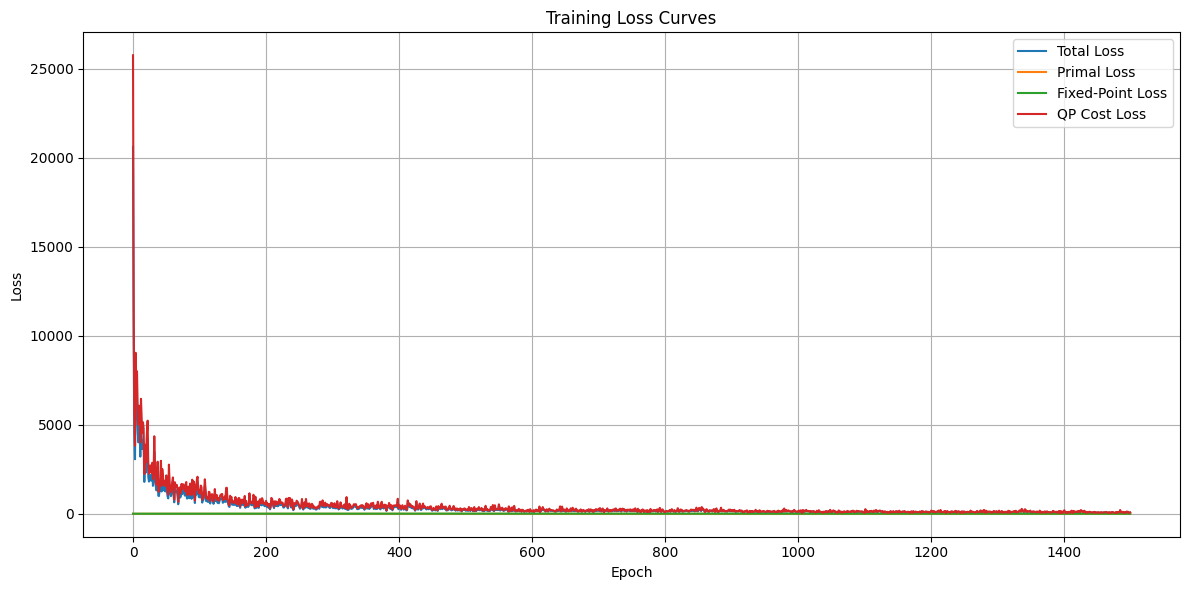

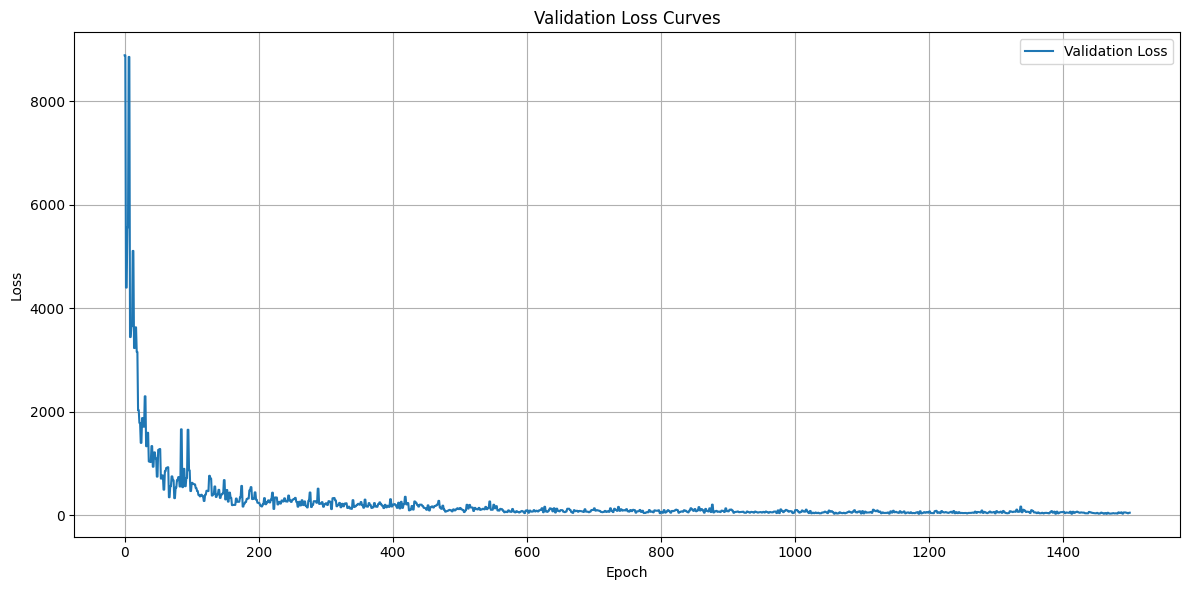

In [58]:
# Plot training losses

plt.figure(figsize=(12, 6))

plt.plot(avg_train_loss, label='Total Loss')
plt.plot(avg_primal_loss, label='Primal Loss')
plt.plot(avg_fixed_point_loss, label='Fixed-Point Loss')
plt.plot(avg_qp_cost_loss, label='QP Cost Loss')


plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot validation losses
plt.figure(figsize=(12, 6))
plt.plot(avg_val_loss, label='Validation Loss')

plt.title('Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
avg_train_loss = np.asarray(avg_train_loss)
avg_val_loss = np.asarray(avg_val_loss)
avg_fixed_point_loss = np.asarray(avg_fixed_point_loss)
avg_qp_cost_loss = np.asarray(avg_qp_cost_loss)

print("Training_loss_start", avg_train_loss[0])
print("Validation_loss_start", avg_val_loss[0])
print("Fixed_Point_loss_start", avg_fixed_point_loss[0])
print("QP_loss_start", avg_qp_cost_loss[0])

print("Training_loss_end", avg_train_loss[-1])
print("Validation_loss_end", avg_val_loss[-1])
print("Fixed_Point_loss_end", avg_fixed_point_loss[-1])
print("QP_loss_end", avg_qp_cost_loss[-1])

Training_loss_start 20622.031
Validation_loss_start 8885.369
Fixed_Point_loss_start 4.7643847
QP_loss_start 25771.504
Training_loss_end 64.22509
Validation_loss_end 49.936077
Fixed_Point_loss_end 2.6528456
QP_loss_end 76.96531
